### **Importing Libraries**

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import nltk
# nltk.download('punkt')
import time
from transformers import GPT2LMHeadModel, GPT2Tokenizer,GPT2Model, GPT2Config, AdamW
from nltk.tokenize import word_tokenize
import numpy as np
import torch.optim as optim
from rouge_score import rouge_scorer
import string
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction 
import os
import re
import random
import csv
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)


cuda


### **Dataset Loading**

In [2]:
def load_csv(file_path):
    data = []

    with open(file_path, mode='r', encoding='utf-8') as file:
        reader = csv.DictReader(file)
        
        for row in reader:
            data.append({
                'id': row['id'],
                'article': row['article'],
                'highlights': row['highlights']
            })

    return data


train_data = load_csv('./Cleaned_Dataset/train.csv')
test_data = load_csv('./Cleaned_Dataset/test.csv')
val_data = load_csv('./Cleaned_Dataset/validation.csv')


In [3]:
def clean_text(text):
    pattern = r"(?i)(PUBLISHED:\s*.\s*\d{1,2}:\d{2}\s*(EST|PST),\s*\d{1,2}\s\w+\s\d{4}\s*.\s*\|\s*.\s*UPDATED:\s*.\s*\d{1,2}:\d{2}\s*(EST|PST),\s*\d{1,2}\s\w+\s\d{4})|" \
              r"(By\s*.\s*[A-Za-z\s]+.)|" \
              r"(\([A-Za-z\s]*CNN\)\s*--)|" \
              r"(Follow\s*@@[A-Za-z0-9_]+)|" \
              r"(UPDATED:\s*.\s*\d{1,2}:\d{2}\s*(EST|PST),\s*\d{1,2}\s\w+\s\d{4})|" \
              r"(Last\s*updated\s*at\s*\d{1,2}:\d{2}\s*(AM|PM)\s*on\s*\d{1,2}(st|nd|rd|th)\s*\w+\s\d{4}\s*.)|" \
              r"(\(CNN\))"
    
    cleaned_text = re.sub(pattern, '', text).strip()
    cleaned_text = cleaned_text.lower()
    
    return cleaned_text

def clean_articles(data):
    for entry in data:
        entry['article'] = clean_text(entry['article'])
        entry['highlights'] = clean_text(entry['highlights'])
    
    return data

def write_csv(file_path, cleaned_data):
    with open(file_path, mode='w', encoding='utf-8', newline='') as file:
        writer = csv.DictWriter(file, fieldnames=['id', 'article', 'highlights'])
        writer=writer
        writer.writeheader()
        
        for row in cleaned_data:
            writer.writerow(row)

# train_data = clean_articles(train_data)
# test_data = clean_articles(test_data)
# val_data = clean_articles(val_data)

# write_csv("./Cleaned_Dataset/train.csv", train_data)
# write_csv("./Cleaned_Dataset/test.csv", test_data)
# write_csv("./Cleaned_Dataset/validation.csv", val_data)
            
def write_csv(file_path, cleaned_data, percentage=1):
    # Calculate how many rows to write based on the percentage
    data_size = len(cleaned_data)
    num_rows = data_size * percentage // 100

    with open(file_path, mode='w', encoding='utf-8', newline='') as file:
        writer = csv.DictWriter(file, fieldnames=['id', 'article', 'highlights'])
        writer.writeheader()
        
        # Write only the first 'num_rows' rows of the data
        for row in cleaned_data[:num_rows]:
            writer.writerow(row)

# Assuming train_data, test_data, val_data are your datasets
# write_csv("./train.csv", train_data)
# write_csv("./test.csv", test_data)
# write_csv("./validation.csv", val_data)



### **Intialize special Tokens**

In [4]:
# import tokenizer for padding
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

prompt_tokken = "[SUMMARIZE]"
soft_prompt_vocab = ["[SUMMARIZE]"]
soft_prompt_word2idx = {word: idx for idx, word in enumerate(soft_prompt_vocab)}

num_prompts = len([soft_prompt_word2idx[word] for word in prompt_tokken.split()])
prompt_id = torch.tensor([soft_prompt_word2idx[word] for word in prompt_tokken.split()])
# print(prompt_id)

# Initializing Pad tokens
pad_token = tokenizer.eos_token_id
# tokenizer.add_tokens([pad_token])


/home/chetan/anaconda3/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


### **Tokenizing the Data**

In [5]:
def convertCSV(data):
    inp = []
    out = []
    for row in data:
        inp.append(row['article'])
        out.append(row['highlights'])
    
    return inp, out

inp_train, out_train = convertCSV(train_data)
inp_val, out_val = convertCSV(val_data)
inp_test, out_test = convertCSV(test_data)

train_size = int(0.05 * len(inp_train))
inp_train_10 = inp_train[:train_size]
out_train_10 = out_train[:train_size]

val_size = int(0.05 * len(inp_val))
inp_val_10 = inp_val[:val_size]
out_val_10 = out_val[:val_size]

test_size = int(0.05 * len(inp_test))
inp_test_10 = inp_test[:test_size]
out_test_10 = out_test[:test_size]

# print(inp_train[0])
def remove_punctuation(tokenized_sentence):
    return [word for word in tokenized_sentence if word not in string.punctuation]
#Using NLTK Tokenize

inp_train = [remove_punctuation(word_tokenize(sentence)) for sentence in inp_train_10]
inp_test = [remove_punctuation(word_tokenize(sentence)) for sentence in inp_test_10]
inp_val = [remove_punctuation(word_tokenize(sentence)) for sentence in inp_val_10]
out_train = [remove_punctuation(word_tokenize(sentence)) for sentence in out_train_10]
out_test = [remove_punctuation(word_tokenize(sentence)) for sentence in out_test_10]
out_val = [remove_punctuation(word_tokenize(sentence)) for sentence in out_val_10]

print(len(inp_train))
print(len(inp_val))
print(len(inp_test))
# print(out_train[0])

max_len = 0
for i in inp_train:
    # if max_len < len(i):
    max_len += len(i)
    
print(max_len/len(inp_train))

# def tokenize(data,max_len = 1000):

def prepare_data(sentences,pad, max_len=1024):
    all_indices = []
    for _, sentence in enumerate(sentences):

        tokens = tokenizer.encode(sentence,truncation=True,max_length=max_len)
        padded_tokens = torch.tensor(tokens + [pad] * (max_len - len(tokens)))
        
        all_indices.append(padded_tokens)
        
    return all_indices


train_inp = prepare_data(inp_train,pad_token,512-num_prompts)
test_inp = prepare_data(inp_test,pad_token,512-num_prompts)
val_inp = prepare_data(inp_val,pad_token,512-num_prompts)
train_out = prepare_data(out_train,pad_token,512)
test_out = prepare_data(out_test,pad_token, 512)
val_out = prepare_data(out_val,pad_token,512)
# print(train_inp[0])
# print(train_out[0][1023])


14355
668
574
671.0917450365727


### **Model**

In [6]:
class GPT2SoftPrompt(torch.nn.Module):
    def __init__(self, model, num_prompts, emb_size = 768):
        super().__init__()
        self.gpt2 = GPT2LMHeadModel.from_pretrained(model)
        self.gpt2.eval()  # Freeze GPT-2 weights
        for param in self.gpt2.parameters():
            param.requires_grad = False
        self.sprompt = torch.nn.Embedding(num_prompts, emb_size)

    def forward(self, inp, prompt, **kwargs):
        prompt_emb = self.sprompt(prompt)
        gpt2_emb = self.gpt2.transformer.wte(inp)
        emb = torch.cat([prompt_emb, gpt2_emb.squeeze(0)], dim=0)
        attention_mask = torch.ones((emb.size(0), emb.size(1)), device=emb.device)
        outputs = self.gpt2(inputs_embeds=emb, attention_mask=attention_mask)
        return outputs


### **Evaluation Metric**

In [7]:
def calculate_rouge_scores(generated_answers, ground_truth):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)
    total_rouge1, total_rougeL = 0, 0
    for gen, ref in zip(generated_answers, ground_truth):
        scores = scorer.score(gen, ref)
        total_rouge1 += scores['rouge1'].fmeasure
        total_rougeL += scores['rougeL'].fmeasure
    average_rouge1 = total_rouge1 / len(generated_answers)
    average_rougeL = total_rougeL / len(generated_answers)
    return average_rouge1, average_rougeL

### **Train Model**

In [8]:
model = GPT2SoftPrompt("gpt2", num_prompts)
model = model.to(device)

num_epochs = 3
learning_rate = 2e-5
accumulation_steps = 8
clip_value = 1.0
criterion = nn.CrossEntropyLoss(ignore_index=pad_token)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
prompt_id = prompt_id.to(device)
train_losses = []
val_losses = []
start_time = time.time()


for epoch in range(num_epochs):
    train_rouge1_scores = []
    train_rouge2_scores = []
    train_rougeL_scores = []
    model.train()
    total_loss = 0
    with tqdm(enumerate(zip(train_inp, train_out)), total=len(train_inp), desc=f"Epoch {epoch + 1}/{num_epochs}", unit="batch") as progress:
        train_percentage_matched = 0
        train_percentage_matched_ct = 0
        for i, (article, summary) in progress:
            context_words = article.to(device)
            target_words = summary.to(device)

            outputs = model(context_words, prompt_id, labels=target_words)
            logits = outputs.logits if hasattr(outputs, "logits") else outputs.last_hidden_state

            loss = criterion(outputs.logits, target_words)

            loss.backward()
            total_loss += loss.item()

            if (i + 1) % accumulation_steps == 0 or (i+1) == len(train_inp):
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                optimizer.zero_grad()
            
            gpu_memory_allocated = torch.cuda.memory_allocated() / 1024**2 
            gpu_memory_reserved = torch.cuda.memory_reserved() / 1024**2 
            progress.set_postfix(
                curr_loss=loss.item(),
                gpu_allocated=f'{gpu_memory_allocated:.2f} MB',
                gpu_reserved=f'{gpu_memory_reserved:.2f} MB'
            )


            predictions = logits.argmax(dim=-1).squeeze(0).tolist()
            references = summary.squeeze(0).tolist()

            decoded_predictions = tokenizer.decode([token for token in predictions if token != pad_token])
            decoded_references = tokenizer.decode([token for token in references if token != pad_token])

            rouge1, rougeL = calculate_rouge_scores([decoded_predictions], [decoded_references])
            train_rouge1_scores.append(rouge1)
            train_rougeL_scores.append(rougeL)


        avg_train_loss = total_loss / len(train_inp)
        train_losses.append(avg_train_loss)
        avg_train_rouge1_score = sum(train_rouge1_scores) / len(train_rouge1_scores)
        avg_train_rougeL_score = sum(train_rougeL_scores) / len(train_rougeL_scores)

        print("Average Training ROUGE-1 Score:", avg_train_rouge1_score)
        print("Average Training ROUGE-L Score:", avg_train_rougeL_score)



    # Validation loop
    model.eval()  # Set model to evaluation mode
    total_val_loss = 0
    val_rouge1_scores = []
    val_rougeL_scores = []

    with tqdm(enumerate(zip(val_inp, val_out)), total=len(val_inp), desc=f"Validation", unit="batch") as progress:
        for _, (val_article, val_summary) in progress:
            context_words = val_article.to(device)
            target_words = val_summary.to(device)

            with torch.no_grad():
                outputs = model(context_words, prompt_id)
                logits = outputs.logits if hasattr(outputs, "logits") else outputs.last_hidden_state

                loss = criterion(logits, target_words)
                total_val_loss += loss.item()  

                predictions = logits.argmax(dim=-1).squeeze(0).tolist()
                references = val_summary.squeeze(0).tolist()

                decoded_predictions = tokenizer.decode([token for token in predictions if token != pad_token])
                decoded_references = tokenizer.decode([token for token in references if token != pad_token])

                rouge1, rougeL = calculate_rouge_scores([decoded_predictions], [decoded_references])
                val_rouge1_scores.append(rouge1)
                val_rougeL_scores.append(rougeL)

        avg_val_loss = total_val_loss / len(val_inp)  
        val_losses.append(avg_val_loss)

        avg_val_rouge1_score = sum(val_rouge1_scores) / len(val_rouge1_scores)
        avg_val_rougeL_score = sum(val_rougeL_scores) / len(val_rougeL_scores)

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
        print("Average Validation ROUGE-1 Score:", avg_val_rouge1_score)
        print("Average Validation ROUGE-L Score:", avg_val_rougeL_score)
                
end_time = time.time()
training_time = end_time - start_time
print("Time taken to train is: ", training_time)
peak_memory_allocated = torch.cuda.max_memory_allocated() / 1024**2
print(f'Peak GPU memory allocated: {peak_memory_allocated:.2f} MB')


Epoch 1/3: 100%|██████████| 14355/14355 [29:55<00:00,  7.99batch/s, curr_loss=10.6, gpu_allocated=656.39 MB, gpu_reserved=1452.00 MB]


Average Training ROUGE-1 Score: 0.000429389352233774
Average Training ROUGE-L Score: 0.00042662894623603004


Validation: 100%|██████████| 668/668 [00:38<00:00, 17.39batch/s]


Epoch [1/3], Train Loss: nan, Val Loss: 9.9522
Average Validation ROUGE-1 Score: 0.0002671788377959908
Average Validation ROUGE-L Score: 0.0002671788377959908


Epoch 2/3: 100%|██████████| 14355/14355 [30:05<00:00,  7.95batch/s, curr_loss=11, gpu_allocated=657.89 MB, gpu_reserved=1452.00 MB]  


Average Training ROUGE-1 Score: 0.0004214462658973754
Average Training ROUGE-L Score: 0.00041839841470030453


Validation: 100%|██████████| 668/668 [00:38<00:00, 17.40batch/s]


Epoch [2/3], Train Loss: nan, Val Loss: 9.7199
Average Validation ROUGE-1 Score: 0.00027414335984676704
Average Validation ROUGE-L Score: 0.00027414335984676704


Epoch 3/3: 100%|██████████| 14355/14355 [30:13<00:00,  7.92batch/s, curr_loss=10.1, gpu_allocated=657.89 MB, gpu_reserved=1452.00 MB]


Average Training ROUGE-1 Score: 0.0004475219439426132
Average Training ROUGE-L Score: 0.0004436144647565024


Validation: 100%|██████████| 668/668 [00:39<00:00, 17.06batch/s]

Epoch [3/3], Train Loss: nan, Val Loss: 9.5959
Average Validation ROUGE-1 Score: 0.0002778111850316729
Average Validation ROUGE-L Score: 0.0002778111850316729
Time taken to train is:  5529.59471321106
Peak GPU memory allocated: 1319.63 MB


### **Plotting Results**

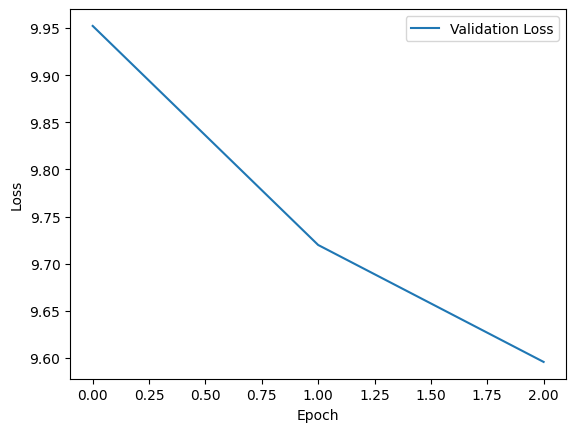

In [13]:
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
# plt.show()
plt.savefig("./plot_1.png")

### **Save Model**

In [12]:
torch.save(model, './model_1.pth')

[nan, nan, nan]


### **Testing**

In [11]:
# Test Loop
model.eval()  # Set the model to evaluation mode

total_test_loss = 0
test_losses = []
test_rouge1_scores = []
test_rougeL_scores = []

with tqdm(enumerate(zip(test_inp, test_out)), total=len(test_inp), desc="Testing", unit="batch") as progress:
    for _, (test_article, test_summary) in progress:
        context_words = test_article.to(device)
        target_words = test_summary.to(device)

        with torch.no_grad():
            outputs = model(context_words, prompt_id)
            logits = outputs.logits if hasattr(outputs, "logits") else outputs.last_hidden_state

            loss = criterion(logits, target_words)
            total_test_loss += loss.item()  # Accumulate test loss

            predictions = logits.argmax(dim=-1).squeeze(0).tolist()
            references = test_summary.squeeze(0).tolist()

            decoded_predictions = tokenizer.decode([token for token in predictions if token != pad_token])
            decoded_references = tokenizer.decode([token for token in references if token != pad_token])

            rouge1, rougeL = calculate_rouge_scores([decoded_predictions], [decoded_references])
            test_rouge1_scores.append(rouge1)
            test_rougeL_scores.append(rougeL)

avg_test_loss = total_test_loss / len(test_inp)
test_losses.append(avg_test_loss)

avg_test_rouge1_score = sum(test_rouge1_scores) / len(test_rouge1_scores)
avg_test_rougeL_score = sum(test_rougeL_scores) / len(test_rougeL_scores)

# Print results
print(f"Test Loss: {avg_test_loss:.4f}")
print("Average Test ROUGE-1 Score:", avg_test_rouge1_score)
print("Average Test ROUGE-L Score:", avg_test_rougeL_score)


Testing: 100%|██████████| 574/574 [00:33<00:00, 17.24batch/s]

Test Loss: 9.6197
Average Test ROUGE-1 Score: 0.00038469301756902254
Average Test ROUGE-L Score: 0.0003650075906905407


### **Generation**

In [14]:
model.eval()

input_text = "the bishop of the fargo catholic diocese in north dakota has exposed potentially hundreds of church members in fargo, grand forks and jamestown to the hepatitis a virus in late september and early october. the state health department has issued an advisory of exposure for anyone who attended five churches and took communion. bishop john folda (pictured) of the fargo catholic diocese in north dakota has exposed potentially hundreds of church members in fargo, grand forks and jamestown to the hepatitis a . state immunization program manager molly howell says the risk is low, but officials feel it's important to alert people to the possible exposure. the diocese announced on monday that bishop john folda is taking time off after being diagnosed with hepatitis a. the diocese says he contracted the infection through contaminated food while attending a conference for newly ordained bishops in italy last month. symptoms of hepatitis a include fever, tiredness, loss of appetite, nausea and abdominal discomfort. fargo catholic diocese in north dakota (pictured) is where the bishop is located ."
input_ids = tokenizer.encode(input_text, truncation=True, max_length=1023)

input_ids = torch.tensor(input_ids)

with torch.no_grad():
    outputs = model(input_ids.to(device),prompt_id)
    pred_logits = outputs.logits


predicted_token_ids = torch.argmax(pred_logits, dim=-1)

predicted_tokens = tokenizer.decode([token for token in predicted_token_ids if token != pad_token])
print(predicted_tokens)

., of the churchier ofolic churchocese of the-arota. been the dangerous of thousands members to theargo, a j of other-own. the world Ce. the Mayptember. early Octoberober.
 bishop of department said said a alert to the to the who has the or in five part with
 ofs,,left) has the fargo diolic diocese in north dakota has exposed potentially hundreds of church members in fargo, grand forks and jamestown to the hepatitis a virus
 healthization program has,ichael (e ( the hepatitis of high and but the are it's a to keep people to the risk risk. " stateocese of the itsolly that it john folda of no communion off from a diagnosed with hepatitis A . the diocese announced it is the virus in a food and in a church in thew priests. the's. year. the of hepatitis a. fever, headacheness, and of appetite, and, vomiting pain. theargo isolic diocese in north dakota haspictured) has taking the hepatitis of being. the
